# Subsurface Machine Learning: Feature Ranking for Subsurface Data Analytics

#### Variable Ranking

There are often many predictor features, input variables, available for us to work with for subsurface prediction. There are good reasons to be selective, throwing in every possible feature is not a good idea! In general, for the best prediction model, careful selection of the fewest features that provide the most amount of information is the best practice.

Here's why:

more variables result in more complicated workflows that require more professional time and have increased opportunity for blunders
higher dimensional feature sets are more difficult to visualize
more complicated models may be more difficult to interrogate, interpret and QC
inclusion of highly redundant and colinear variables increases model instability and decreases prediction accuracy in testing
more variables generally increase the computational time required to train the model and the model may be less compact and portable
the risk of overfit increases with the more variables, more complexity

#### What is Feature Ranking?

Feature ranking is a set of metrics that assign relative importance or value to each feature with respect to information contained for inference and importance in predicting a response feature. There are a wide variety of possible methods to accomplish this. My recommendation is a 'wide-array' approach with multiple metric, while understanding the assumptions and limitations of each metric.

Here's the general types of metrics that we will consider for feature ranking.

Visual Inspection of Data Distributions and Scatter Plots
Statistical Summaries
Model-based
Recursive Feature Elimination
Also, we should not neglect expert knowledge. If additional information is known about physical processes, causation, reliability and availability of features this should be integrated into assigning feature ranks.

In [3]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trigonometry etc.
import scipy.signal as signal             # kernel for moving window calculation
import random                             # for randon numbers
import seaborn as sns                     # for matrix scatter plots
from scipy import linalg                  # for linear regression
from sklearn.feature_selection import RFE # for recursive feature selection
from sklearn.linear_model import LinearRegression # linear regression model

Here's a couple of functions  for metrics that we will calculate below.

In [4]:
#Partial Correlation in Python (clone of Matlab's partialcorr)

#This uses the linear regression approach to compute the partial correlation 
#(might be slow for a huge number of variables). The algorithm is detailed here:

# http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression

#Taking X and Y two variables of interest and Z the matrix with all the variable minus {X, Y},
#the algorithm can be summarized as
#    1) perform a normal linear least-squares regression with X as the target and Z as the predictor
#    2) calculate the residuals in Step #1
#    3) perform a normal linear least-squares regression with Y as the target and Z as the predictor
#    4) calculate the residuals in Step #3
#    5) calculate the correlation coefficient between the residuals from Steps #2 and #4; 
#    The result is the partial correlation between X and Y while controlling for the effect of Z

#Date: Nov 2014
#Author: Fabian Pedregosa-Izquierdo, f@bianp.net
#Testing: Valentina Borghesani, valentinaborghesani@gmail.com

def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

In [9]:

df = pd.read_csv(r'C:\Users\Hp\Desktop\project_data.csv')  
df.head(10)

,WellIndex,Por,LogPerm,AI,Brittle,TOC,VR,Production
0,1,15.91,1.67,3.06,14.05,1.36,1.85,177.381958
1,2,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778
2,3,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583
3,4,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629
4,5,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919
5,6,19.47,2.04,2.73,54.37,1.42,2.12,5497.005506
6,7,12.70,1.30,3.70,43.03,0.45,1.95,1784.266285
7,8,14.15,1.23,2.53,39.43,0.79,1.54,1943.639213
8,9,16.18,1.34,3.45,45.79,0.56,1.95,3176.523611
9,10,20.51,2.48,2.78,28.99,1.78,2.24,2522.792318


This dataset has features from 200 unconventional wells including:

#well index
#well average porosity (%)
#permeability (mD)
#accoustic impedance (kg/m2s*10^6)
#brittness ratio (%)
#total organic carbon (%)
#vitrinite reflectance (%)
#normalized initial production 90 day average (MCFPD).
Note, the dataset is synthetic, but has realistic ranges and general multivariate relationships.

Ranking features is really an effort to understand the features and their relationships with eachother. We will start with basic data visualization and move to more complicated methods such are partial correlation and recursive feature elimination.

#### Ranking Method #1 - Summary Statistics

In any multivariate work we should start with the univariate analysis, summary statistics of one variable at a time. The summary statistic ranking method is qualitative, we are asking:

are there data issues?
do we trust the features? do we we trust the features all equally?
are there issues that need to be taken care of before we develop any multivariate workflows?
There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a compact data table. We use transpose() command to flip the table so that features are on the rows and the statistics are on the columns.

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
WellIndex,1000.0,500.500000,288.819436,1.000000,250.75000,500.50000,750.250000,1000.00000
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.719480,15.077006,-10.500000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.003810,0.504978,-0.260000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


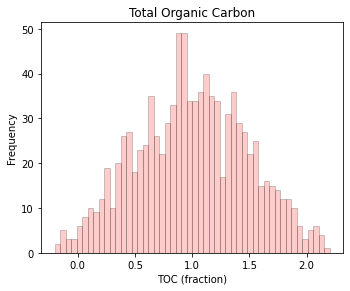

In [11]:
plt.subplot(111)
GSLIB.hist_st(df['TOC'].values,-.2,2.2,log=False,cumul = False,bins=50,weights = None,xlabel='TOC (fraction)',title='Total Organic Carbon')
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.7, top=0.8, wspace=0.1, hspace=0.2)
plt.show()

In [12]:
df['TOC'] = np.where(df['TOC']<0.0, 0.0, df['TOC']) # set TOC < 0.0 as 0.0, otherwise leave the same
df['TOC'].describe().transpose()          # summary statistics just for TOC

count    1000.000000
mean        1.006170
std         0.499838
min         0.000000
25%         0.640000
50%         0.995000
75%         1.360000
max         2.710000
Name: TOC, dtype: float64

We can also establish the feature ranges for plotting. We could calculate the feature range directly from the data with code like this:
p
Pormin = np.min(df['Por'].values)          # extract ndarray of data table column
Pormax = np.max(df['Por'].values)          #and calculate min and max
but, this would not result in easy to understand color bars and axis scales, let's pick convenient round numbers. We will also declare feature labels for ease of plotting.

In [13]:
pormin = 6.0; pormax = 24.0; porname = 'Porosity (%)'; portitle = 'Porosity' # user specified min and max values, and labels for plotting
permmin = 0.0; permmax = 10; permname = 'Permeability (mD)'; permtitle = 'Permeability'                
AImin = 1.0; AImax = 5.0; AIname = 'Acoustic Impedance (kg/m2s*10^6)'; AItitle = 'Acoustic Impedance'
brmin = 10.0; brmax = 85.0; brname = 'Brittleness Ratio (%)'; brtitle = 'Brittleness'
TOCmin = 0.0; TOCmax = 2.2; TOCname = 'Total Organic Carbon (%)'; TOCtitle = 'Total Organic Carbon' 
VRmin = 0.9; VRmax = 2.9; VRname = 'Vitrinite Reflectance (%)'; VRtitle = 'Vitrinite Reflectance'
prodmin = 500.0; prodmax = 9000.0; prodname = 'Normalized Initial Production (MCFPD)'; prodtitle = 'Normalized Initial Production'

#### Ranking Method #2 - Univariate Distributions

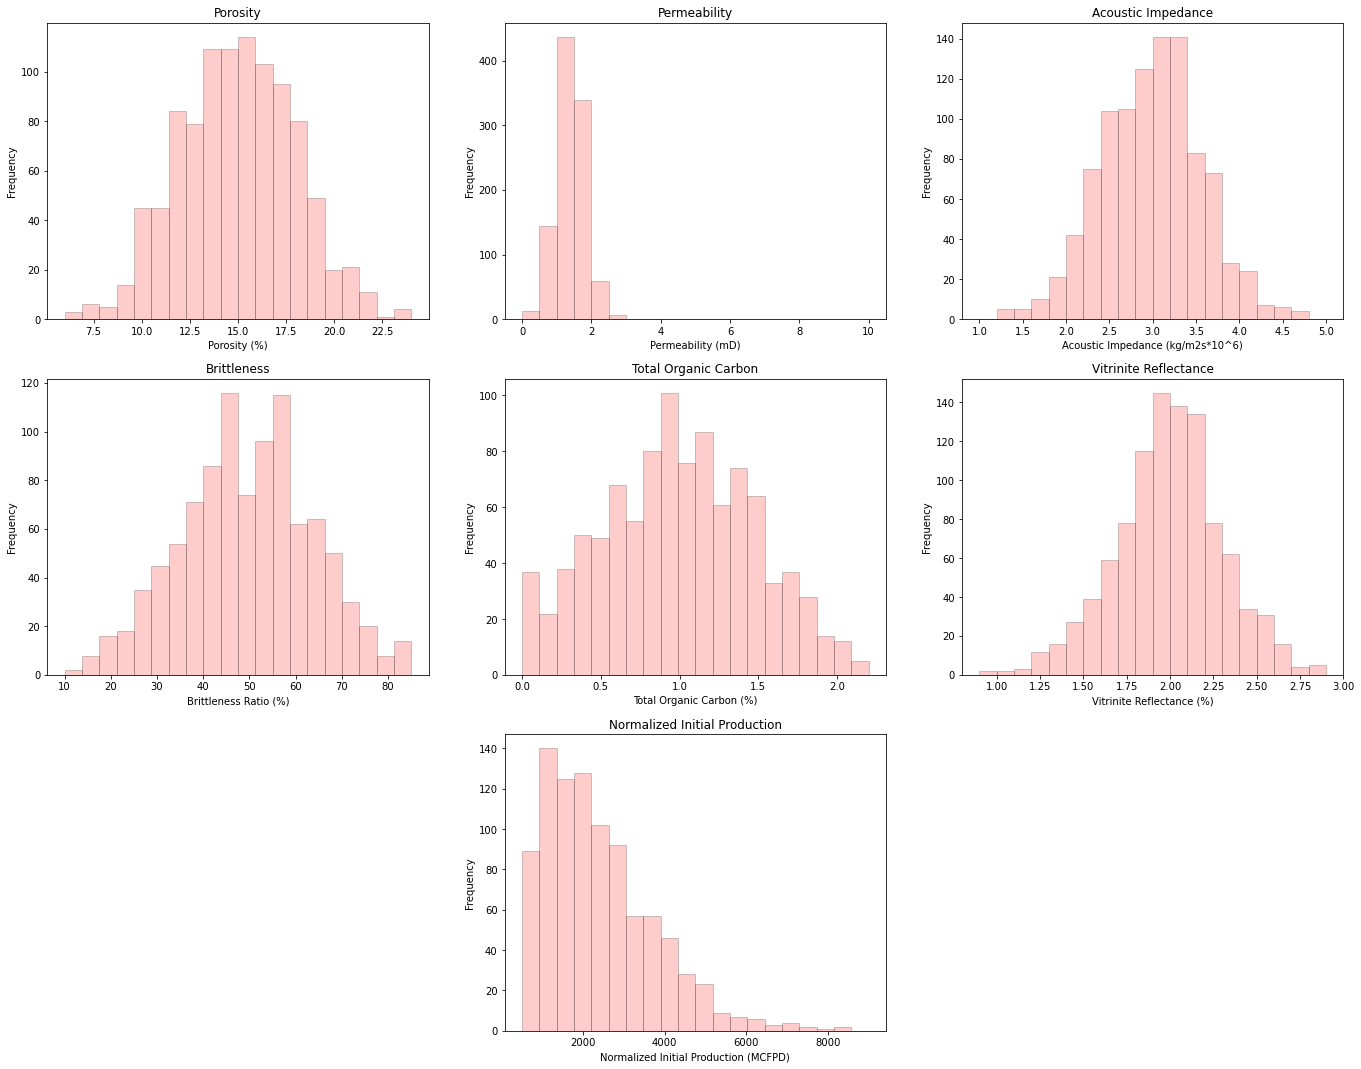

In [21]:
plt.subplot(331)
GSLIB.hist_st(df['Por'].values,pormin,pormax,log=False,cumul = False,bins=20,weights = None,xlabel=porname,title=portitle)

plt.subplot(332)
GSLIB.hist_st(df['LogPerm'].values,permmin,permmax,log=False,cumul = False,bins=20,weights = None,xlabel=permname,title=permtitle)

plt.subplot(333)
GSLIB.hist_st(df['AI'].values,AImin,AImax,log=False,cumul = False,bins=20,weights = None,xlabel=AIname,title=AItitle)

plt.subplot(334)
GSLIB.hist_st(df['Brittle'].values,brmin,brmax,log=False,cumul = False,bins=20,weights = None,xlabel=brname,title=brtitle)

plt.subplot(335)
GSLIB.hist_st(df['TOC'].values,TOCmin,TOCmax,log=False,cumul = False,bins=20,weights = None,xlabel=TOCname,title=TOCtitle)

plt.subplot(336)
GSLIB.hist_st(df['VR'].values,VRmin,VRmax,log=False,cumul = False,bins=20,weights = None,xlabel=VRname,title=VRtitle)

plt.subplot(338)
GSLIB.hist_st(df['Production'].values,prodmin,prodmax,log=False,cumul = False,bins=20,weights = None,xlabel=prodname,title=prodtitle)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.2, hspace=0.2)
plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")
plt.show()

### Ranking Method #3 - Bivariate Distributions

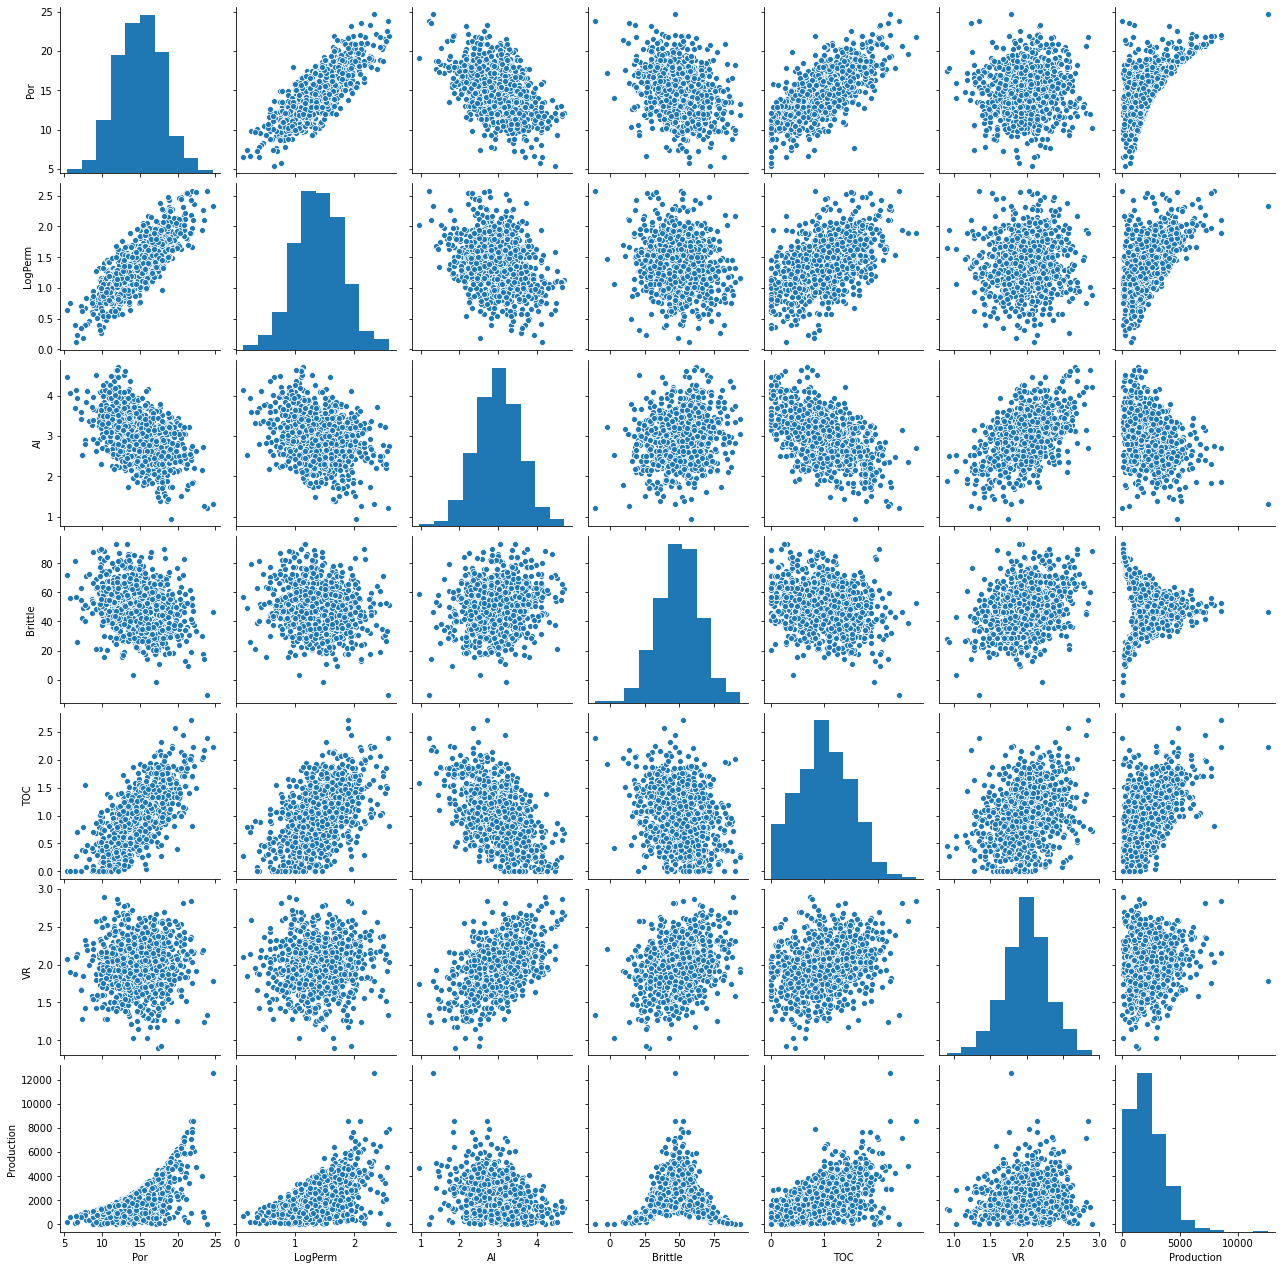

In [22]:
sns.pairplot(df,vars=['Por','LogPerm','AI','Brittle','TOC','VR','Production'],markers='o')

This plot communicates a lot of information. How could we use this plot for variable ranking?

we can identify variables that are closely related to eachother. e.g. if two variables have almost a perfect monotonic linear or near linear relationship we should remove one immediately. This is a simple case of colinearity that will likley result in model instability as discussed above.

we can check for linear vs. non-linear relationships. If we observe nonlinear bivariate relationships this will impact the choice of methods, and the quality of results from methods that assume linear relationships for variable ranking.

we can identify constraint relationships and heteroscedasticity between variables. Once again these may restrict our ranking methods and also encourage us to retains specific features to retain these features in the resulting model.

Yet, we must remember that bivariate visualization and analysis is not sufficient to understand all the multivariate relationships in the data. Multicollinearity includes strong linear relationships between 2 or more features. These may be hard to see with only bivariate plots.

#### Ranking Method #4 - Pairwise Covariance

Pairwise covariance provides a measure of the strength of the linear relationship between each predictor feature and the response feature. At this point, we specify that the goal of this study is to predict production, our response variable, from the other available predictor features. We are thinking predictively now, not inferentially, we want to estimate the function, $\hat{f}$, to accomplish this:

$$
Y = \hat{f}(X_1,\ldots,X_n) 
$$
where $Y$ is our response feature and $X_1,\ldots,X_n$ are our predictor features. If we retained all of our predictor features to predict the response we would have:

$$
Prod = \hat{f}(Por,Perm,AI,Brittle,TOC,VR) 
$$
Now back to the covariance, the covariance is defined as:

$$
C_{xy}  = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{(n-1)}
$$
Covariance:

measures the linear relationship
sensitive to the dispersion / variance of both the predictor and response

In [23]:
covariance = df.iloc[:,1:8].cov().iloc[6,:6]
print(covariance)

Por        3046.853208
LogPerm     338.140453
AI         -276.288089
Brittle   -1577.008127
TOC         368.886128
VR           64.265553
Name: Production, dtype: float64


The covariance is useful, but as you can see the magnitude is quite variable. Most importantly these magnitudes are a function of each feature's variance. Feature variance is somewhat arbitrary. For example, what is the variance of porosity in fraction vs. percentage or permeaiblity in Darcy vs. milliDarcy. We can show that if we apply a constant multiplier, $c$, to a variable, $X$, that the variance will change according to this relationship (the proof is based on expectation formulation of variance):

$$
\sigma_{cX}^2 = c^2 \cdot \sigma_{X}^2
$$
By moving from percentage to fraction we decrease the variance of porosity by a factor of 10,000! The variance of each variable is potentially arbitrary, with the exception when all the features are in the same units.

Pairwise correlations avoids this issue.

#### Ranking Method #5 Pairwise Correlation Coefficient

Pairwise correlation coefficient provides a measure of the strength of the linear relationship between each predictor feature and the response feature.

$$
\rho_{xy}  = \frac{\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}{(n-1)\sigma_x \sigma_y}, \, -1.0 \le \rho_{xy} \le 1.0
$$
The correlation coefficient:

measures the linear relationship
removes the sensitiviety to the dispersion / variance of both the predictor and response features, by normalizing by the product of the standard deviation of each feature
We can use the follow command to build a correlation matrix:

p
df.iloc[:,1:8].corr()
the output is a new Pandas DataFrame, so we can slice the last column to get a Pandas series (ndarray with names) with the correlations between all predictors features and the response.

In [24]:
correlation = df.iloc[:,1:8].corr().iloc[6,:6]
print(correlation)

Por        0.686822
LogPerm    0.568841
AI        -0.326660
Brittle   -0.071433
TOC        0.504018
VR         0.142409
Name: Production, dtype: float64


This is interesting.

We see that porosity, permeability and total organic carbon have the strongest linear relationships with production.
Acoustic impedance has weak negative relationships with production.
Brittleness is very close to 0.0. If you review the brittleness vs. production scatterplot, you'll observe a complicated non-linear relationship. There is a brittleness ratio sweetspot for production (rock that is not too soft nor too hard)!

#### Ranking Method #6 Semipartial Correlation Coefficient

This is a linear correlation coefficient that controls for the effects all the remaining features, $Z$ on $X$, and then calculates the correlation between the residual $X^*-X$ and $Y$. Note: we do not control for influence of $Z$ features on the response feature, $Y$.

To calculate the semipartial correlation coefficient between $X$ and $Y$ given $Z_i, \forall \quad i = 1,\ldots, m-1$ remaining features we use the following steps:

perform linear, least-squares regression to predict $X$ from $Z_i, \forall \quad i = 1,\ldots, m-1$. $X$ is regressed on the remaining predictor features to calculate the estimate, $X^*$

calculate the residuals in Step #1, $X-X^*$, where $X^* = f(Z_{1,\ldots,m-1})$, linear regression model

calculate the correlation coefficient between the residuals from Steps #2 and $Y$ response feature, $\rho_{X-X^*,Y}$

In [26]:
semipartial_correlation = semipartial_corr(df.iloc[:,1:8])
semipartial_correlation = semipartial_correlation[:,6][:6]
print(semipartial_correlation)

[0.17516128 0.15211305 0.07436027 0.02705911 0.01117434 0.22722983]


More information to consider:

porosity, permeability and vitrinite reflectance are the most important by this feature ranking method
all other predictor features have quite low correlations

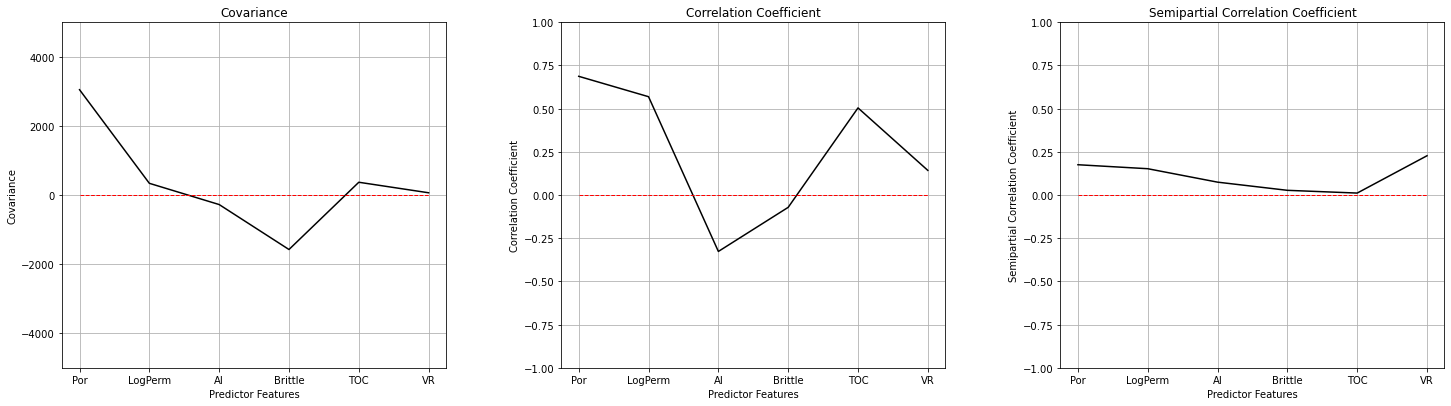

In [27]:
features = df.columns.values[1:][:6]
plt.subplot(131)
plt.plot(features,covariance,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-5000,5000)
plt.grid(True)

plt.subplot(132)
plt.plot(features,correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)


plt.subplot(133)
plt.plot(features,semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()


#### Repeat with Standardization or Normal Score Transform of All Features

Just as a check, let's standardize all the features and repeat the previously calculated quantitative methods. We know this will have an impact on covariance, what about the partial and semipartial correlations?

There is a bunch of code to get this done, but it isn't too complicated. First, lets make a new DataFrame with all variables standardized. Then we can make a minor edit (change the DataFrame name) and reuse the code from above. You can choose between:

Afine Correction - scale the distributions to have $\overline{x} = 0$ and $\sigma_x = 1.0$.
Normal Score Transform - distribution transform of each feature to standard normal, Gaussian shape with $\overline{x} = 0$ and $\sigma_x = 1.0$.
Use this block to perform affine correction of the features:

In [30]:
dfS = pd.DataFrame()
dfS['WellIndex'] = df['WellIndex'].values
dfS['Por'] = GSLIB.affine(df['Por'].values,0.0,1.0)
dfS['LogPerm'] = GSLIB.affine(df['LogPerm'].values,0.0,1.0)
dfS['AI'] = GSLIB.affine(df['AI'].values,0.0,1.0)
dfS['Brittle'] = GSLIB.affine(df['Brittle'].values,0.0,1.0)
dfS['TOC'] = GSLIB.affine(df['TOC'].values,0.0,1.0)
dfS['VR'] = GSLIB.affine(df['VR'].values,0.0,1.0)
dfS['Production'] = GSLIB.affine(df['Production'].values,0.0,1.0)
dfS.head()

,WellIndex,Por,LogPerm,AI,Brittle,TOC,VR,Production
0,1,0.316877,0.668174,0.134046,-2.367004,0.708244,-0.458285,-1.414335
1,2,0.128641,0.618884,-0.662712,-1.183816,0.728261,-0.653065,-0.524438
2,3,1.816157,1.530747,0.255292,0.925747,1.568954,1.749222,1.485405
3,4,-0.990866,-0.638008,1.588995,0.603241,-1.213341,0.126055,-0.518596
4,5,1.512338,1.062493,-0.714674,-0.396131,0.788310,0.385762,2.059275


In [31]:
dfS = pd.DataFrame()
dfS['WellIndex'] = df['WellIndex'].values
dfS['Por'],d1,d2 = geostats.nscore(df,'Por')
dfS['LogPerm'],d1,d2 = geostats.nscore(df,'LogPerm')
dfS['AI'],d1,d2 = geostats.nscore(df,'AI')
dfS['Brittle'],d1,d2 = geostats.nscore(df,'Brittle')
dfS['TOC'],d1,d2 = geostats.nscore(df,'TOC')
dfS['VR'],d1,d2 = geostats.nscore(df,'VR')
dfS['Production'],d1,d2 = geostats.nscore(df,'Production')
dfS.head()

,WellIndex,Por,LogPerm,AI,Brittle,TOC,VR,Production
0,1,0.298921,0.669777,0.099174,-2.483769,0.679218,-0.508647,-1.968592
1,2,0.086587,0.614326,-0.626480,-1.167521,0.704695,-0.714367,-0.394787
2,3,1.792831,1.576112,0.233981,0.932651,1.534121,1.700696,1.415234
3,4,-0.964092,-0.632592,1.602704,0.644888,-1.128758,0.162388,-0.383971
4,5,1.576112,1.064726,-0.676064,-0.413828,0.777269,0.424776,1.831674


In [32]:
dfS.describe()

,WellIndex,Por,LogPerm,AI,Brittle,TOC,VR,Production
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03
mean,500.500000,2.044186e-03,0.012521,0.008618,3.521094e-04,0.016438,0.016536,1.185749e-04
std,288.819436,9.990656e-01,0.999597,1.001842,9.998829e-01,0.983736,0.999100,9.994658e-01
min,1.000000,-3.058571e+00,-3.128442,-3.541681,-3.287018e+00,-2.085764,-3.015949,-3.171952e+00
25%,250.750000,-6.737039e-01,-0.663516,-0.661977,-6.737039e-01,-0.657281,-0.644888,-6.737039e-01
50%,500.500000,1.110223e-15,0.016294,0.016294,1.110223e-15,0.006267,0.033846,1.110223e-15
75%,750.250000,6.760640e-01,0.711136,0.682378,6.737039e-01,0.679218,0.681666,6.737039e-01
max,1000.000000,3.290527e+00,3.290527,3.290527,3.290527e+00,3.290527,3.290527,3.290527e+00


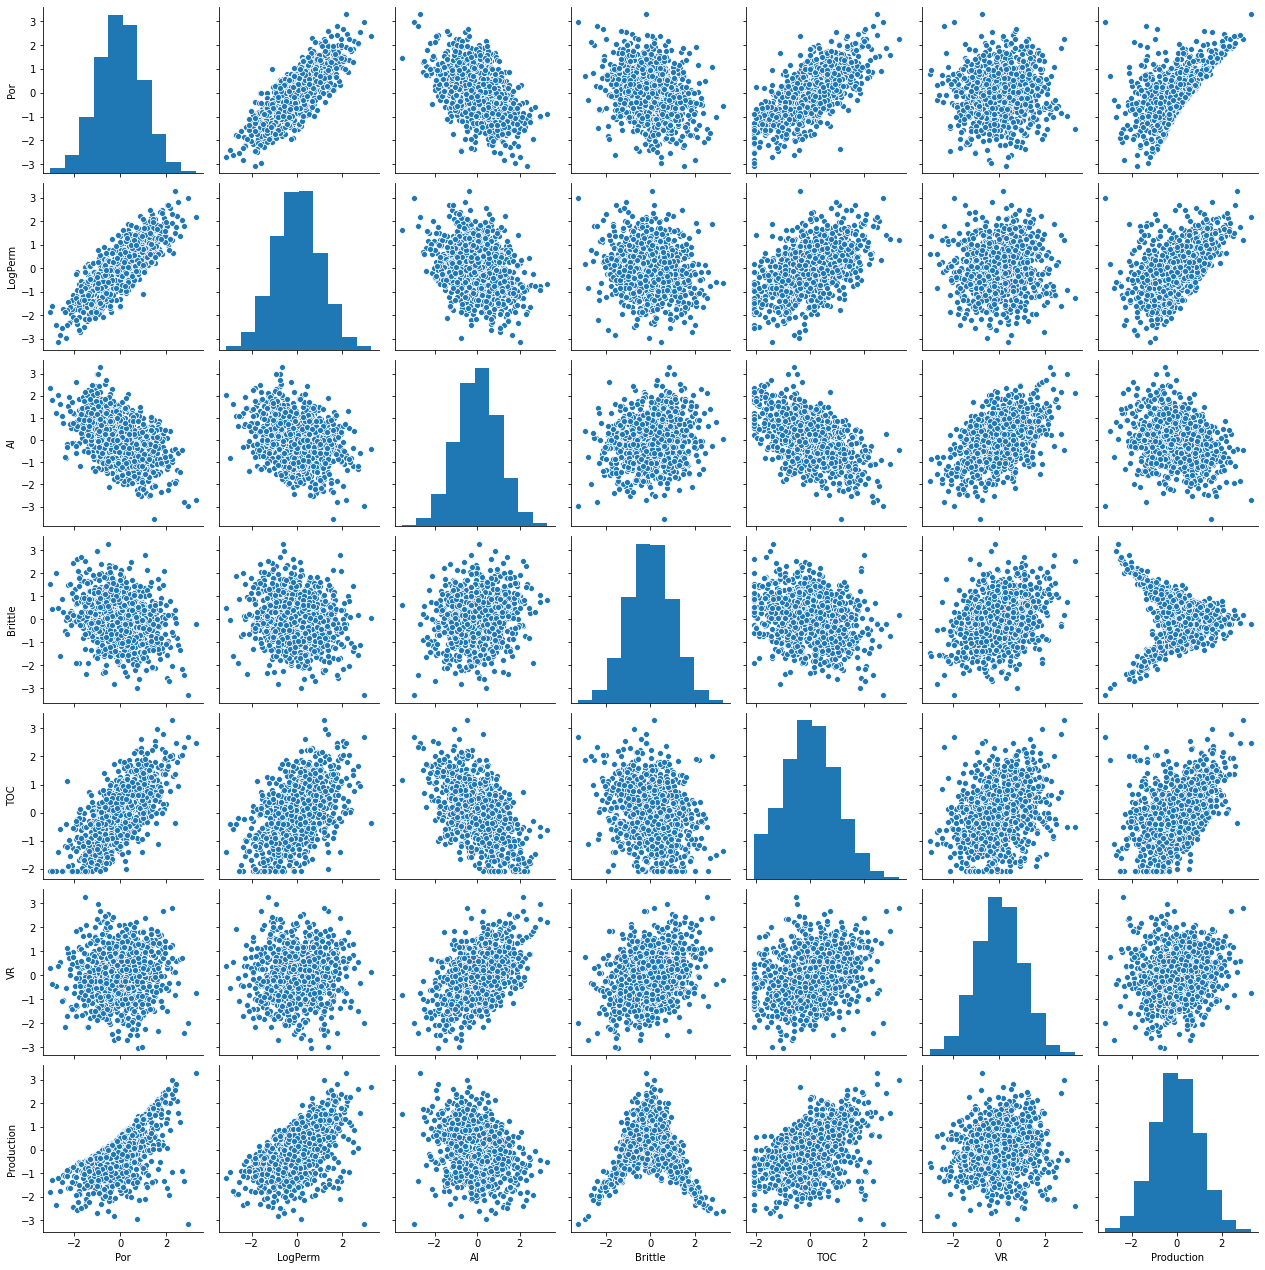

In [33]:
sns.pairplot(dfS,vars=['Por','LogPerm','AI','Brittle','TOC','VR','Production'],markers='o')

In [34]:
stand_covariance = dfS.iloc[:,1:8].cov().iloc[6,:6]
stand_correlation = dfS.iloc[:,1:8].corr().iloc[6,:6]
stand_rank_correlation, stand_rank_correlation_pval = stats.spearmanr(dfS.iloc[:,1:8])
stand_rank_correlation = stand_rank_correlation[:,6][:6]

stand_semipartial_correlation = semipartial_corr(dfS.iloc[:,1:8])
stand_semipartial_correlation = stand_semipartial_correlation[:,6][:6]

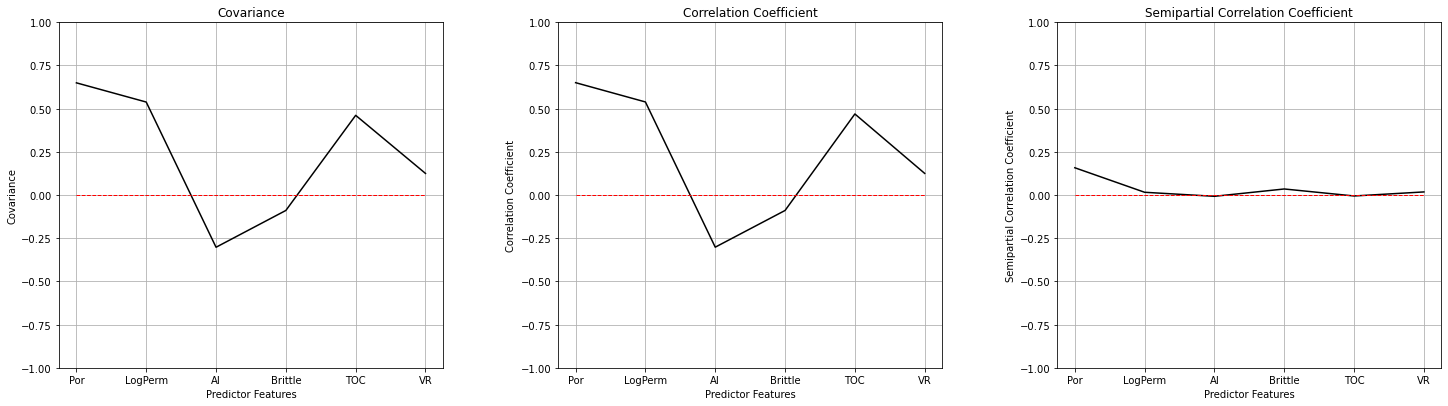

In [35]:
features = df.columns.values[1:][:6]
plt.subplot(131)
plt.plot(features,stand_covariance,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(132)
plt.plot(features,stand_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)



plt.subplot(133)
plt.plot(features,stand_semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

covariance is now equal to correlation coefficient
the semipartial correlations are sensitive to the feature standardization (affine correlation or normal score transform).
Model-based Feature Ranking

#### Ranking Method #7 $B$ Coefficients / Beta Weights

We could also consider $B$ coefficients. These are the linear regression coefficients without standardization of the variables. Let's use the linear regression method that is available in the SciPy package.

The estimator for $Y$ is simply the linear equation:

$$
Y^* = \sum_{i=1}^{m} b_i X_i + c
$$
The $b_i$ coefficients are solved to minimize the squared error between the estimates, $Y^*$ and the values in the training dataset, $Y$.

In [38]:
df['const'] = np.ones(len(df))                  # let's add one for the constant term
b = linalg.lstsq(df.iloc[:,[1,2,3,4,5,6,8]],df.iloc[:,[7]])[0]
df = df.drop('const',axis = 1)
print(b[0:6])

[[ 314.20132128]
 [ 160.26164122]
 [-150.4153506 ]
 [   7.26440004]
 [ -76.57310734]
 [ 475.97757652]]


The ouput is the $b$ coefficients, ordered over our features from $b_i, i = 1,\ldots,n$ and then the intercept, $c$, that I have removed to avoid confusion.

we see the negative contribution of AI and TOC
the results are very sensitive to the magnitudes of the variances of the predictor features.
We can remove this sensitivity by working with standardized features.

#### Ranking Method #8 Recursive Feature Elimination

Recursive Feature Elimination (RFE) method works by recursively removing features and building a model with the remaining features.

model accuracy is applied to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute
In this code we make a prediction model based on multilinear regression and indicate that we want to find the best feature based on recursive feature elimination. The algorithm assigns rank $1,\ldots,m$ for all features.

In [39]:
rfe = RFE(LinearRegression(), 1,verbose=0)      # set up RFE linear regression model
df['const'] = np.ones(len(df))                  # let's add one's for the constant term
rfe = rfe.fit(df.iloc[:,[1,2,3,4,5,6,8]].values,np.ravel(df.iloc[:,[7]])) # recursive elimination
dfS = df.drop('const',axis = 1)                 # remove the ones
print(rfe.ranking_[0:6])                             # print the variable ranks

[2 5 3 6 4 1]


In [41]:
df.columns

Index(['WellIndex', 'Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR',
       'Production', 'const'],
      dtype='object')

The recursive feature elimination method with a linear regression model provides these ranks:


Vitrinite Reflectance
Porosity
AI
TOC
Permeability
Brittleness
A couple of the features moved from our previous assessment, but we are close. The advantages with the recursive elimination method:

the actual model can be used in assessing feature ranks
the ranking is based on accuracy of the estimate
but this method is sensitive to:

choice of model
training dataset
This method may be applied with cross validation (k fold iteration of training and testing datasets)